## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *
from corrections import *
from image_reading import * 
from handling import *
from preprocessing import * 

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

In [2]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 60
    pady = 30

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])


    adapted_para_box[x[:2],0] = np.max( np.stack(( paragraph_vertices[x[:2],0] - padx , [0,0] )), axis=0)

    adapted_para_box[x[2:],0] = np.min( np.stack(( paragraph_vertices[x[2:],0] + 1.2*padx , [frame.shape[1] - 1,frame.shape[1] - 1] )), axis=0)

    adapted_para_box[y[:2],1] = np.max( np.stack(( paragraph_vertices[y[:2],1] - pady, [0,0] )), axis=0) 
    adapted_para_box[y[2:],1] = np.min( np.stack(( paragraph_vertices[y[2:],1] + pady , [frame.shape[0] - 1,frame.shape[0] - 1])), axis=0)


    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,6,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    from skimage.segmentation import clear_border
    # kernel = np.ones((5, 5), np.uint8)
    # frame = cv2.erode(frame, kernel, iterations=1)
    
    # frame = clear_border(frame)

    if verbose: ax[5].imshow(frame)

    return frame

-


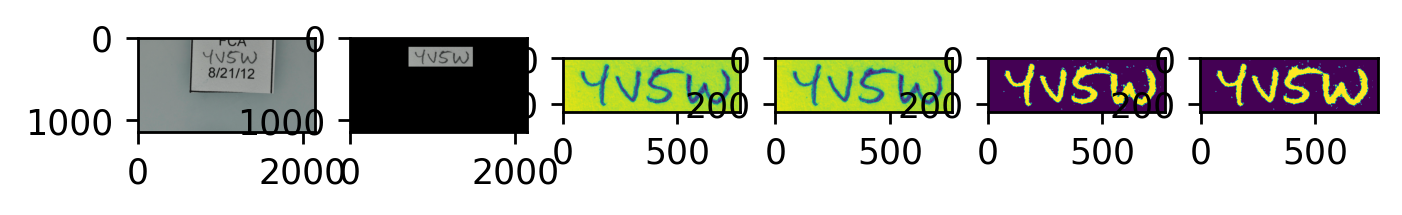

In [4]:
file = 'Manually_Labelled/New/CA1208/FCA4V5W1208.JPG'
image_in_bytes = RetreiveImage(file)

client = vision.ImageAnnotatorClient()
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client)

identity_box = combine_boxes(character_boxes)

%matplotlib inline
ID = extract_ID_handwriting(frame, identity_box, verbose=True)

print(output_string)

In [279]:
folders = ['Manually_Labelled/New/CA1208', 'Manually_Labelled/New/CA1207' ,'Manually_Labelled/New/CA1206','Manually_Labelled/New/CA1209jpegs JB']

bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = []
for folder in folders:
    s_file_list = storage_client.list_blobs(bucket_name,prefix=folder)
    s_file_list = [file.name for file in s_file_list]
    file_list.extend(s_file_list)

In [280]:
def extract_ID(file_list):
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]

        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

In [281]:
IDs = np.array(extract_ID(file_list))

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 15 lower height: 1017
C pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: C upper height: 17 lower height: 1121
A pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: A upper height: 20 lower height: 1231
3 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
character: 3 upper height: 155 lower height: 888
√ pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
character: √ upper height: 153 lower height: 1050
7 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
character: 7 upper height: 152 lower height: 1221
4 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
character: 4 upper height: 151 lower height: 1409
8 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
character: 8 upper height: 401 lower height: 891
/ pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
character: / upper height: 402 lower height: 978
2 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
charac

ValueError: all input arrays must have the same shape

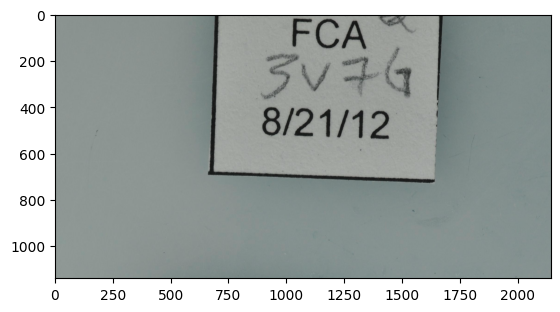

In [282]:
frame, para_box = GetImageAndParaBox(file_list[78], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)
label_ID = IDs[78]

In [283]:
image_width, image_height = 256, 64

In [284]:
characters = []
for i in IDs:
    for j in i:
        if j not in characters:
            characters.append(j)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_len = len(max(IDs, key=len))

In [285]:
model = tf.keras.Sequential()
model.add(char_to_num)
model.add(num_to_char)
model.build(input_shape=(1,1))
model.save('stringlookups.h5') #need to save these lookup tables for use in model.

/Users/jordan/anaconda3/envs/Guppies/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [286]:
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [287]:
vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

NameError: name 'label_ID' is not defined

In [288]:
# # h5f.close()
# h5f = h5py.File(('dataset.h5'), 'w')

# image_width, image_height = 256, 64
   
# first_image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
# first_label = vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

# h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
# h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,max_len))


In [289]:
# some_im_IDs = []
# some_label_IDs = []

# idx = np.arange(0, len(file_list))
# np.random.shuffle(idx)


# for i in range(len(file_list)):
#     st = str(i)
#     try: 
#         frame, para_box = GetImageAndParaBox(file_list[idx[i]], client = client, verbose=False)
#         im_ID = extract_ID_handwriting(frame, para_box, verbose=False)


#         image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
#         label = vectorize_label(IDs[idx[i]], char_to_num, max_len=max_len, padding_token=99).numpy()[None]

#         h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
#         h5f['images'][-1:] = image

#         h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
#         h5f['labels'][-1:] = label

#         # some_im_IDs.append(im_ID)
#         # some_label_IDs.append(IDs[idx[i]])
#         st += ' success'

#     except: st += ' fail'
#     print(st)

# h5f.close()
    

V pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: V upper height: 189 lower height: 1283
M pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:0
character: M upper height: 252 lower height: 924
C pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:1
character: C upper height: 254 lower height: 1044
A pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:2
character: A upper height: 256 lower height: 1141
6 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:0
character: 6 upper height: 392 lower height: 798
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:1
character: 7 upper height: 396 lower height: 950
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:2
character: 7 upper height: 400 lower height: 1107
V pageno:0 blockno:1 paragraphno:0 wordno:2 symbolno:0
character: V upper height: 403 lower height: 1236
8 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:0
character: 8 upper height: 581 lower height: 831
/ pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:1
char

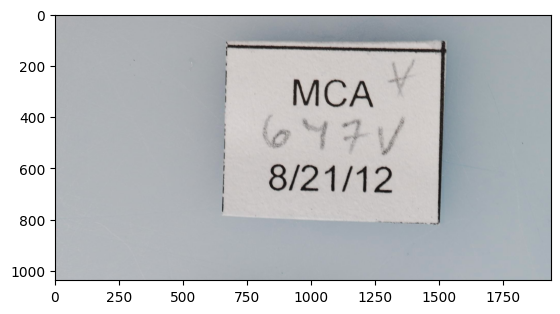

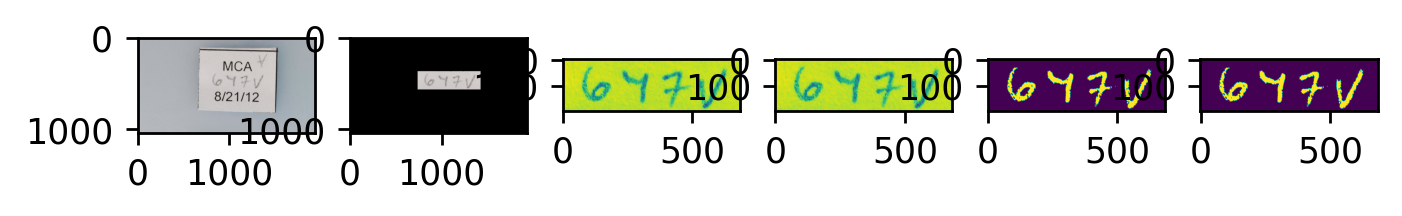

In [298]:
frame, para_boxes = GetImageAndParaBox(file_list[209], client = client, verbose=True)
para_box = combine_paraboxes(para_boxes)
im_ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [299]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

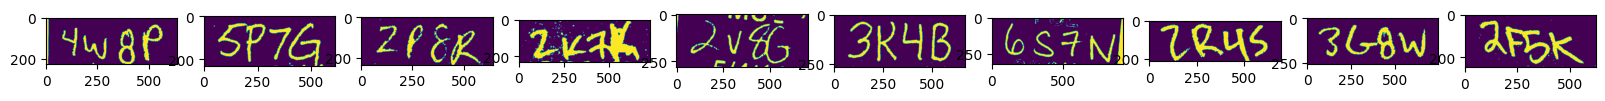

In [300]:
client = vision.ImageAnnotatorClient()

fig,ax = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    frame, para_boxes = GetImageAndParaBox(new_jpg_files[i], client, verbose=False)
    para_box = combine_paraboxes(para_boxes)
    try:
        ID = extract_ID_handwriting(frame, para_box, verbose=False)
        ax[i].imshow(ID)
        # ax[i//10, i%10].imshow(ID)
        # ax[i//10, i%10].set_title('Index: %i' %i)
    except:
        pass

# plt.tight_layout()

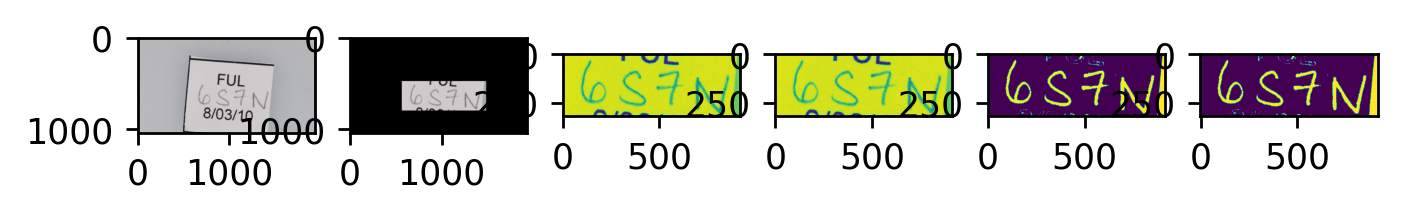

In [303]:
file = new_jpg_files[6]
frame, para_boxes = GetImageAndParaBox(file, client, verbose=False)
para_box = combine_paraboxes(para_boxes)

ID = extract_ID_handwriting(frame, para_box, verbose=True)
plt.imshow(ID)
# print(file)

## Lets isolate single characters

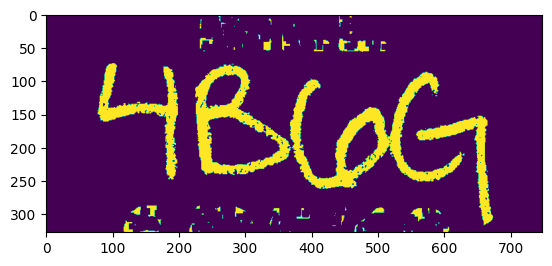

In [ ]:
plt.imshow(ID)

In [ ]:
num_components, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(ID))

In [ ]:
rel_components = np.where(stats[:,-1] >800)[0][1:]

In [ ]:
stats = stats[rel_components]

# stats = np.sort(stats, axis=0) #sort by their x coordinate to get in right order

In [ ]:
characters = []
pad = 10

for i in range(rel_components.shape[0]):

    y_start,x_start,width,height = stats[i,:4]

    char = labels[x_start-pad:x_start+height+pad,y_start-pad:y_start+width+pad] == rel_components[i]

    characters.append(char)

print(characters)
characters = np.array(characters)
characters = characters[np.argsort(stats[:,0])]
fig,ax = plt.subplots(1,rel_components.shape[0],figsize=(10,5))
for i in range(rel_components.shape[0]):
    ax[i].imshow(characters[i])
    ax[i].axis('off')

[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

### now need to pad somewhat and get into 28$\times$28 format

In [ ]:
samples = torch.zeros((len(characters), 1, 28, 28))

for i, char in enumerate(characters):


    #here we should really scale up if w and h are too small.
    h,w = char.shape
    pooler = torch.nn.AvgPool2d(10)

    
    eg = np.uint8(char)

    eg = cv2.dilate(eg, np.ones((5,5)), iterations = 1)

    if h>w:
        resize_h = 260
        resize_w = int(w * (resize_h/h))
        pad = (resize_h - resize_w)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((10,10),(pad,280-resize_w-pad)), mode = 'constant', constant_values = 0))
        
    else:
        resize_w = 260
        resize_h = int(h * (resize_w/w))
        pad = (resize_w - resize_h)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((pad,280-resize_h-pad),(10,10),), mode = 'constant', constant_values = 0))

    samples[i] = pooler(char.unsqueeze(0).unsqueeze(0))

samples = samples / torch.amax(samples, dim = (1,2,3), keepdim = True)

samples = samples* 255


error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/morph.dispatch.cpp:1022: error: (-215:Assertion failed) !src.empty() in function 'dilate'


In [ ]:
cnn_let = torch.load('letter_model.pth')
cnn_num = torch.load('number_model.pth')

relevant_characters =  ['0','1','2','3','4','5','6','7','8','B','F','G','K','N','O','P','R','S','V','W','Y'] 

nums = relevant_characters[:9]
letters = relevant_characters[9:]

def preds_to_char(preds, chars):
    pred_idx = torch.max(preds, 1)[1].data.numpy().squeeze()
    return np.array([chars[i] for i in pred_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'letter_model.pth'

In [ ]:
letter_preds = cnn_let(samples[::2])[0]
number_preds = cnn_num(samples[1::2])[0]

letter_preds_decoded = preds_to_char(letter_preds, letters)
number_preds_decoded = preds_to_char(number_preds, nums)

a = len(number_preds_decoded)
b = len(letter_preds_decoded)
string = ''
for i in range(a):
    string += number_preds_decoded[i]
    string += letter_preds_decoded[i]
if b > a:
    string += letter_preds_decoded[-1]



fig,ax = plt.subplots(1,len(samples),figsize=(10,10))
for i in range(len(samples)):
    ax[i].imshow(samples[i,0],cmap='gray')
    ax[i].set_title(string[i])
    ax[i].axis('off')



NameError: name 'cnn_let' is not defined

[5, 6, 12]
[5, 6]
length of bounding boxes 2
Also included character 5 in bounding
Also included character 3 in bounding


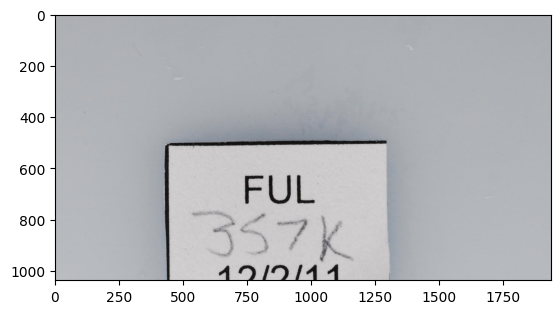

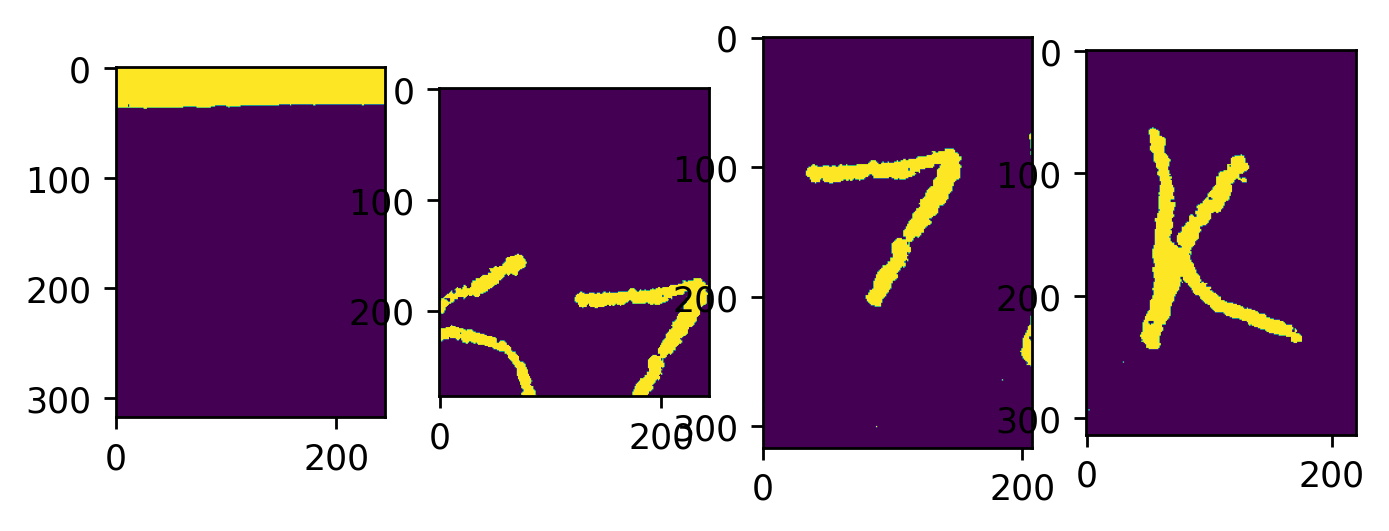

In [ ]:
file = new_jpg_files[50]
client = vision.ImageAnnotatorClient()
frame, para_boxes = GetImageAndParaBox(file, client, verbose=False)

# ordered_para_boxes

fig,ax = plt.subplots(1,len(para_boxes),dpi=250)

for i, para_box in enumerate(para_boxes):
    box = combine_paraboxes([para_box])

    %matplotlib inline
    ID = extract_ID_handwriting(frame, box, verbose=False)
        
    ax[i].imshow(ID)

deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row
deleted row


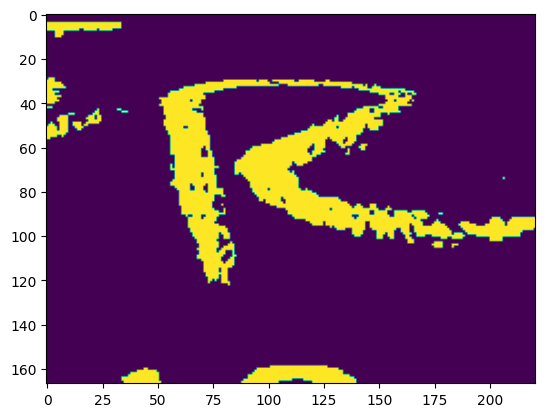

In [ ]:
for n, row in enumerate(ID):
        if np.array_equal(row, np.zeros(len(row))):
            try:
                ID = np.delete(ID, n, axis=0)
            except:
                pass

for j, column in enumerate(np.transpose(ID)):
    if np.array_equal(column, np.zeros(len(column))):
        try:
            ID = np.delete(ID, j, axis=1)
        except:
            pass
        
plt.imshow(ID)